In [2]:
pip install setfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 6.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 685.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 1.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.2 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.9 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.1/262.1 kB 4.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━

In [3]:
pip install pytorch

  Preparing metadata (setup.py) ... - \ | done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-rnz4zjtb/pytorch_81f5cb6ff3694edeae8620f8f1e1efbb/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  Running setup.py install for pytorch ... - error
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]


In [54]:
pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip show scikit-multilearn

Name: scikit-multilearn
Version: 0.2.0
Summary: Scikit-multilearn is a BSD-licensed library for multi-label classification that is built on top of the well-known scikit-learn ecosystem.
Home-page: http://scikit.ml/
Author: Piotr Szymański
Author-email: niedakh@gmail.com
License: BSD
Location: /anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import sys
import mlflow
from skmultilearn.model_selection import IterativeStratification
from sklearn import metrics
import emoji


import transformers
from transformers import AutoModel 
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig

from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../../Data/go_emotions_dataset.csv")

# getting results from last experiment
results_auc = pd.read_csv("emotion_results_auc.csv", index_col=0)
results = pd.read_csv("emotion_results.csv", index_col=0)

#grouping into a single df
df = df.groupby(["text","id"]).max().reset_index()

#cateories
categories = df.columns.values[3:]

# Train test split

In [3]:
# # 10 lowest categories
# lowest = df[categories].sum().sort_values().head(10).index
# lowest

## Helper functions for sampling

In [4]:
def conditional_probs(df, labels):
    lst=[]
    for i in labels:
        filtered = df[df[i]==1]
        probs = filtered[labels].sum()/filtered.shape[0]
        probs.name = i 
        lst.append(probs)
    
    return pd.concat(lst,axis=1)

In [5]:
#p(row|column)
conditional = conditional_probs(df,categories)
conditional.style.background_gradient(cmap='coolwarm')

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
admiration,1.000000,0.169269,0.054848,0.078302,0.220478,0.162480,0.077617,0.104408,0.177237,0.083471,0.072245,0.079596,0.082834,0.335706,0.072829,0.324571,0.116071,0.315845,0.375770,0.075787,0.205669,0.455674,0.125517,0.212903,0.063101,0.066724,0.193734,0.102750
amusement,0.088357,1.000000,0.052548,0.073919,0.075756,0.044711,0.057508,0.061293,0.060254,0.052395,0.054630,0.059882,0.087325,0.131343,0.051354,0.067301,0.037500,0.219482,0.083733,0.039820,0.066516,0.070922,0.076828,0.060829,0.051082,0.047476,0.088251,0.059227
anger,0.031197,0.057259,1.000000,0.291990,0.055686,0.067527,0.080248,0.075129,0.054264,0.158084,0.156629,0.313455,0.165170,0.047302,0.116713,0.025168,0.146429,0.028157,0.033539,0.107900,0.042197,0.049645,0.072000,0.045161,0.081731,0.109495,0.086945,0.085620
annoyance,0.079098,0.143050,0.518577,1.000000,0.144722,0.140585,0.181733,0.164254,0.128259,0.329830,0.339205,0.458600,0.351297,0.096441,0.225490,0.063386,0.226786,0.073452,0.070728,0.225434,0.121759,0.118794,0.186897,0.102304,0.180889,0.220274,0.169452,0.165752
approval,0.294053,0.193561,0.130573,0.191074,1.000000,0.303065,0.168953,0.147683,0.268147,0.189461,0.203047,0.160424,0.177146,0.234214,0.170401,0.202274,0.123214,0.255509,0.228382,0.181760,0.330971,0.346631,0.308966,0.350230,0.158053,0.166595,0.171279,0.224217
caring,0.070947,0.037401,0.051840,0.060769,0.099223,1.000000,0.036083,0.042632,0.124383,0.070260,0.066413,0.043371,0.063872,0.057405,0.082166,0.096197,0.123214,0.085869,0.104495,0.107900,0.166210,0.113475,0.068690,0.157604,0.137019,0.110992,0.029243,0.066777
confusion,0.041562,0.058994,0.075548,0.096334,0.067834,0.044250,1.000000,0.330598,0.059197,0.084522,0.101047,0.072696,0.108283,0.053961,0.077031,0.034862,0.067857,0.035852,0.038102,0.098266,0.070060,0.054965,0.107172,0.035945,0.085938,0.057742,0.146997,0.093107
curiosity,0.065311,0.073453,0.082626,0.101713,0.069267,0.061074,0.386206,1.000000,0.123679,0.072211,0.075815,0.072449,0.089820,0.123077,0.078431,0.047726,0.064286,0.061385,0.057039,0.091843,0.078273,0.064716,0.105241,0.042396,0.086538,0.064371,0.209399,0.103131
desire,0.050619,0.032967,0.027247,0.036262,0.057421,0.081355,0.031573,0.056467,1.000000,0.042486,0.032611,0.025136,0.029940,0.071642,0.031746,0.043997,0.055357,0.053340,0.074835,0.043031,0.152037,0.067376,0.046759,0.048848,0.043870,0.039991,0.029243,0.042160
disappointment,0.055953,0.067284,0.186306,0.218868,0.095224,0.107859,0.105807,0.077381,0.099718,1.000000,0.211259,0.235584,0.298403,0.057405,0.207283,0.047912,0.296429,0.057363,0.052019,0.271034,0.090514,0.083333,0.161793,0.097696,0.278846,0.388152,0.116188,0.105352


In [6]:
#Naive sampling, taking the target amount of examples from each class. 
def naive_sample(df,labels, target_amount):
    lst = []
    amount_lst=[]
    for label in labels:
        n=target_amount
        #filter by cat
        #filtered = df[((df[np.delete(categories,np.where(categories==cat))]==0).all(axis=1)) & df[cat]==1]
        filtered = df[df[label]==1]

        if filtered.shape[0] < n:
            warnings.warn("""Target amount is greater than the number of exmaples in the df. Will take the max instead""")
            n = filtered.shape[0]
            filtered = filtered.sample(n=n, random_state=42)
        else:
            filtered = filtered.sample(n=n, random_state=42)
        
        amount_lst.append(n)
        lst.append(filtered)
    
    amounts = dict(zip(labels,amount_lst))
    sampled_df = pd.concat(lst)
    
    return sampled_df, amounts

In [7]:
#Smarter sampling algorithm using the conditional probabilities and linear regression to decide the sample of each class to take to get as close as possible to the target amount.
from sklearn.linear_model import LinearRegression

def fancy_sample(df, labels, random_state, target_amount):
        
        cond_prob = conditional_probs(df,labels)
        
        # features are the conditional probabilities, labels are the target amount
        X = cond_prob.values
        y = np.array([target_amount]*len(labels))

        #using linear regression to gt the coefficients which are the amounts of each label to sample
        nnls = LinearRegression(positive=True, fit_intercept=False)
        nnls.fit(X,y)

        #creating dictionary of columns and amounts to sample
        amounts = dict(zip(cond_prob.columns,[round(sample) for sample in nnls.coef_]))
        
        row_counts = df[labels].sum()
        
        lst = []
        for emotion in amounts.keys():
            sample_no = amounts[emotion]
            emotion_count = row_counts.loc[emotion]
            
            if sample_no <= emotion_count:
                sample_df = df[df[emotion]==1].sample(n=sample_no,random_state=random_state)
                lst.append(sample_df)
            else:
                #adding warning
                warnings.warn("""The target amount has lead to sample amounts for 1 or more category being larger than the examples in the dataframe. 
                Will sample the max number in the dataframe instead.""")
                amounts[emotion]=emotion_count
                sample_df = df[df[emotion]==1].sample(n=emotion_count,random_state=random_state)
                lst.append(sample_df)
        
        sampled_df = pd.concat(lst)
        
        return sampled_df, amounts

In [8]:
df_train, sample_amounts = fancy_sample(df, labels=categories, random_state=101, target_amount=200)
df_train = df_train.drop_duplicates()

In [9]:
df_train.shape

(1202, 31)

In [10]:
#df_test is everything in df not in df_train
df_test = df[~df["id"].isin(df_train["id"])]

In [11]:
#Stratified train test splitting so the class proportions in the train and validation sets represent the entire set
#taken from scikit multilearn module but have changed some lines
def iterative_train_test_split(X, y, test_size):
    """Iteratively stratified train/test split
    Parameters
    ----------
    test_size : float, [0,1]
        the proportion of the dataset to include in the test split, the rest will be put in the train set
    Returns
    -------
    X_train, y_train, X_test, y_test
        stratified division into train/test split
    """

    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X.iloc[train_indexes, :], y.iloc[train_indexes, :]
    X_test, y_test = X.iloc[test_indexes, :], y.iloc[test_indexes, :]

    return X_train, y_train, X_test, y_test

#Splitting X and y
X = df_test[["text"]]
y = df_test[categories]


#train test split
#splitting testing set into 50% val and test
X_test, y_test, X_rem, y_rem = iterative_train_test_split(X, y, test_size=0.8)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_test, y_test, test_size=0.5)

#viewing the train and test sizes
print(f"Test size: {X_test.shape[0]}")
print(f"Val size: {X_val.shape[0]}")
print(f"Unused size: {X_rem.shape[0]}")


Test size: 5596
Val size: 5661
Unused size: 5596


In [12]:
df_test = pd.concat([X_test,y_test], axis=1)
df_val = pd.concat([X_val,y_val], axis=1)

In [13]:
print(f"Train size: {df_train.shape}")
print(f"Test size: {df_test.shape}")
print(f"Val size: {df_val.shape}")

Train size: (1202, 31)
Test size: (5596, 29)
Val size: (5661, 29)


<AxesSubplot: >

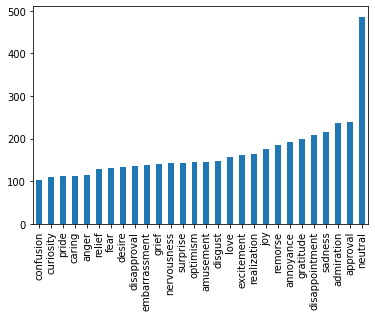

In [14]:
df_train[categories].sum().sort_values().plot(kind="bar")

<AxesSubplot: >

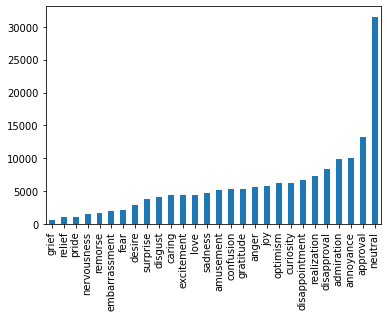

In [15]:
df[categories].sum().sort_values().plot(kind="bar")

Fancy sampling has evened out the classes a bit

In [16]:
# Create labels column for set fit transformer
df_train['labels'] = df_train[categories].values.tolist()
df_val['labels'] = df_val[categories].values.tolist()

In [17]:
df_val.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,labels
13,I don’t give a F F the haters F all the hater...,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20,"No mention of [NAME]? For shame, subreddit. F...",0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, ..."
25,Their official logic is that it reduces turn-...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
39,"future reference: In the sidebar, ""Google doc...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42,"looks unreal, like it's a toy or something.",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
val_dataset = Dataset.from_pandas(df_val.reset_index(drop=True))
train_dataset

Dataset({
    features: ['text', 'id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'labels'],
    num_rows: 1202
})

In [19]:
val_dataset

Dataset({
    features: ['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral', 'labels'],
    num_rows: 5661
})

In [20]:
# Load SetFit model from Hub
#multi target strategy for multi label
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2", 
                                    multi_target_strategy="one-vs-rest")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1, # Number of epochs to use for contrastive learning
    column_mapping={"text": "text", "labels": "label"},
)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [21]:
trainer.train()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 118220
  Num epochs = 1
  Total optimization steps = 7389
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [1:04:42<00:00, 3882.62s/it]
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of itera

In [21]:
metrics = trainer.evaluate()
metrics

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.08075523990992552}

In [22]:
#saving model
model._save_pretrained("setfit/")

In [23]:
pred = trainer.model(df_test.text.values)

In [24]:
y = df_test[categories].values

In [25]:
from sklearn import metrics

#Function to help evaluate model
def create_result_table(prediction_prob, y, categories, threshold=0.5):
    """
        returns a dataframe of all the category metrics when the threshold value is used to make a prediction
        
        predictions: a (n,27) numpy array of all the models predictions 
        y: a (n,27) numpy array of the true values 
        categories: the categories of y.
        threshold: The threshold value from 0 to 1. Used to convert the probabilities into 1s and 0s.

        predictions and y must be the same size. 
    """

    predictions = (prediction_prob>threshold).astype(int)
    results = []

    #adding a neutral category
    # categories = np.append(categories, "neutral")
    # predictions = add_neutral(predictions)
    # y = add_neutral(y)
    
    for i, category in enumerate(categories):
        y_pred = predictions[:,i]
        y_true = y[:,i]
        tp = (y_pred==y_true)&(y_pred==1).astype(int)
        fp = (y_pred!=y_true)&(y_pred==1).astype(int)
        fn = (y_pred!=y_true)&(y_pred==0).astype(int)
        #tn = (y_pred==y_true)&(y_pred==0).astype(int)

        tp = sum(tp)
        fp = sum(fp)
        fn = sum(fn)
        #tn = sum(tn)


        precision = metrics.precision_score(y_true, y_pred)
        recall = metrics.recall_score(y_true, y_pred)
        f1 = metrics.f1_score(y_true, y_pred)

        result = {"category": category,
                    "tp": tp,
                    "fp": fp,
                    "fn": fn,
                    "precision": precision,
                    "recall": recall,
                    "F1": f1
                    }
        
        
        results.append(result)

    results_df = pd.DataFrame.from_dict(results)


    return results_df

In [26]:
pred

tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])

In [27]:
pred.numpy()

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [28]:
setfit_results = create_result_table(pred.numpy(), y, categories)
setfit_results.sort_values("F1",ascending= False)

,category,tp,fp,fn,precision,recall,F1
18,love,331,113,92,0.745495,0.782506,0.763552
27,neutral,2446,945,658,0.721321,0.788015,0.753195
1,amusement,341,139,163,0.710417,0.676587,0.693089
15,gratitude,348,180,169,0.659091,0.673114,0.666029
0,admiration,542,314,428,0.633178,0.558763,0.593647
7,curiosity,299,179,311,0.625523,0.490164,0.549632
25,sadness,185,185,261,0.500000,0.414798,0.453431
17,joy,234,266,320,0.468000,0.422383,0.444023
24,remorse,93,178,55,0.343173,0.628378,0.443914
26,surprise,181,349,187,0.341509,0.491848,0.403118


In [29]:
setfit_results.to_csv("few_shot_result.csv")

In [3]:
#loading setfit result
setfit_results = pd.read_csv("few_shot_result.csv",index_col=0)

In [4]:
bert_results = pd.read_csv("emotion_results_bert.csv",index_col=0)

In [5]:
comparison = bert_results.join(setfit_results.set_index("category"), on="category", rsuffix="_setfit")

In [8]:
comparison.sort_values("F1", ascending=False)

,category,tp,fp,fn,precision,recall,F1,tp_setfit,fp_setfit,fn_setfit,precision_setfit,recall_setfit,F1_setfit
18,love,327,69,111,0.825758,0.746575,0.784173,331,113,92,0.745495,0.782506,0.763552
27,neutral,2196,591,957,0.787944,0.696480,0.739394,2446,945,658,0.721321,0.788015,0.753195
15,gratitude,331,47,205,0.875661,0.617537,0.724289,348,180,169,0.659091,0.673114,0.666029
1,amusement,314,41,205,0.884507,0.605010,0.718535,341,139,163,0.710417,0.676587,0.693089
7,curiosity,453,205,168,0.688450,0.729469,0.708366,299,179,311,0.625523,0.490164,0.549632
0,admiration,593,154,401,0.793842,0.596579,0.681218,542,314,428,0.633178,0.558763,0.593647
24,remorse,76,21,94,0.783505,0.447059,0.569288,93,178,55,0.343173,0.628378,0.443914
14,fear,77,16,129,0.827957,0.373786,0.515050,68,122,139,0.357895,0.328502,0.342569
2,anger,233,113,332,0.673410,0.412389,0.511526,73,34,486,0.682243,0.130590,0.219219
6,confusion,263,262,257,0.500952,0.505769,0.503349,175,219,340,0.444162,0.339806,0.385039


In [36]:
comparison[comparison.F1<comparison.F1_setfit]

,category,tp,fp,fn,precision,recall,F1,tp_setfit,fp_setfit,fn_setfit,precision_setfit,recall_setfit,F1_setfit
11,disgust,78,45,328,0.634146,0.192118,0.294896,120,181,273,0.398671,0.305344,0.345821
16,grief,0,0,63,0.000000,0.000000,0.000000,17,95,26,0.151786,0.395349,0.219355
19,nervousness,8,7,155,0.533333,0.049080,0.089888,40,136,101,0.227273,0.283688,0.252366
21,pride,3,2,101,0.600000,0.028846,0.055046,15,76,97,0.164835,0.133929,0.147783
23,relief,14,20,91,0.411765,0.133333,0.201439,30,148,76,0.168539,0.283019,0.211268
27,neutral,2196,591,957,0.787944,0.696480,0.739394,2446,945,658,0.721321,0.788015,0.753195


* Find out maximum number of rows in few shot due to number of rows in entire set. (plot number of rows with max F1) 
* Try for all emotions and compare with BERT.
* Decide whether to ensemble or keep 1 model.
* Figure out ensemble logic

# Reloading models for explanations

## Reloading BERT

In [1]:
import mlflow
runs = mlflow.search_runs(experiment_names=["Remmy_DistilBERT"])
#show all completed runs
runs[runs["status"]=="FINISHED"]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.PR AUC,metrics.test_micro_prec,metrics.test_macro_rec,metrics.val_recall,...,params.epochs,params.steps_per_epoch,params.workers,params.sample_weight,params.model_name,params.dropout,params.max_length,tags.mlflow.user,tags.mlflow.rootRunId,tags.mlflow.runName
0,c56e304c-7295-48b9-b546-be9488dea7ea,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-01-30 14:19:39.533000+00:00,2023-01-30 14:20:27.620000+00:00,NaN,NaN,NaN,NaN,...,3,None,1,None,None,None,None,Remigius Ezeabasili,c56e304c-7295-48b9-b546-be9488dea7ea,None
1,04f17dd1-7f66-437e-a617-e2638b7c7201,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-01-30 14:20:41.922000+00:00,2023-01-30 15:21:02.717000+00:00,0.511273,0.946429,0.005412,0.007720,...,3,None,1,None,None,None,None,Remigius Ezeabasili,04f17dd1-7f66-437e-a617-e2638b7c7201,None
2,ae1bd0ec-92a2-4437-8289-608ec0509150,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-01-30 15:53:20.653000+00:00,2023-01-30 16:52:05.539000+00:00,0.581591,0.834483,0.016242,0.018016,...,3,None,1,None,None,None,None,Remigius Ezeabasili,ae1bd0ec-92a2-4437-8289-608ec0509150,None
3,f0c8a00a-ec64-4098-97b6-57a5020e21d1,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-01-30 17:13:54.692000+00:00,2023-01-30 18:14:13.128000+00:00,0.609881,0.824000,0.015495,0.016301,...,3,None,1,None,None,None,None,Remigius Ezeabasili,f0c8a00a-ec64-4098-97b6-57a5020e21d1,None
4,87c70b8c-5c96-4431-91f1-011cb263a92f,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-01-31 15:00:06.698000+00:00,2023-01-31 15:00:56.449000+00:00,NaN,NaN,NaN,NaN,...,3,None,1,None,None,None,None,Remigius Ezeabasili,87c70b8c-5c96-4431-91f1-011cb263a92f,None
5,1718135d-673f-452b-b457-8920a0c7167d,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-01-31 15:01:09.963000+00:00,2023-01-31 15:02:14.616000+00:00,NaN,NaN,NaN,NaN,...,3,None,1,None,None,None,None,Remigius Ezeabasili,1718135d-673f-452b-b457-8920a0c7167d,None
6,99657cc5-35d9-4206-bc0d-ceb6ffd80d6c,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-01-31 15:02:23.236000+00:00,2023-01-31 15:19:27.653000+00:00,0.540142,0.570969,0.258848,0.298285,...,3,None,1,None,None,None,None,Remigius Ezeabasili,99657cc5-35d9-4206-bc0d-ceb6ffd80d6c,None
7,fd4a80f7-b1d5-48d8-87a3-654bbdbea4d2,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-02-01 13:24:34.301000+00:00,2023-02-01 13:49:41.975000+00:00,0.703208,0.500113,0.276846,0.344013,...,4,None,1,None,None,None,None,Remigius Ezeabasili,fd4a80f7-b1d5-48d8-87a3-654bbdbea4d2,None
8,3ab207a6-b9b3-4e6c-b192-a3f538e6f50b,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-02-01 13:52:51.334000+00:00,2023-02-01 13:53:06.654000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,Remigius Ezeabasili,3ab207a6-b9b3-4e6c-b192-a3f538e6f50b,None
9,adeffc3e-4eff-4155-a049-a527891112d0,90c6e781-a9f0-48b5-961c-75c55dd87fae,FINISHED,,2023-02-01 13:55:38.707000+00:00,2023-02-01 14:08:49.951000+00:00,0.086676,0.000000,0.000000,0.000000,...,3,None,1,None,None,None,None,Remigius Ezeabasili,adeffc3e-4eff-4155-a049-a527891112d0,None


In [2]:
run_id="6bb9bc12-d81e-46d1-b909-3b1400a5ac79"

In [3]:
from mlflow.tracking import MlflowClient
import mlflow.keras

# Use MlFlow to retrieve the job that was just completed
client = MlflowClient()
client.list_artifacts(run_id)
artifact_path = "model"
model_local_path = mlflow.artifacts.download_artifacts(
  run_id=run_id, artifact_path=artifact_path
)

In [4]:
#reloading
bert_model = mlflow.keras.load_model(model_local_path 
                                #,compile = False
                                #,custom_objects = {'optimizer': optimizer}
                                )

2023-03-22 15:04:58.144167: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 15:05:09.441323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [15]:
model_path = "tmp/keras_save"

#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

bert_model.save("bert_model.h5")

In [4]:
import tensorflow as tf
bert_model = tf.keras.model.load_model("bert_model.h5")

AttributeError: module 'keras.api._v2.keras' has no attribute 'load_model'

In [12]:
bert_model.summary()

Model: "DistilBERT_MultiLabel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, None)]            0         
                                                                 
 distilbert (Custom>TFDistil  {'last_hidden_state': (N  66362880 
 BertMainLayer)              one, None, 768)}                    
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 pooled_output (Dropout)     (None, 768)               0         
                                                                 
 output (Dense)              (None, 28)                21532     
                                                                 
Total params: 66,384,412
Trainable params: 66

In [67]:
def predict_proba(sentence):
    MODEL_NAME = 'distilbert-base-uncased'
    MAX_LENGTH = 200
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
    
    if type(sentence) == str:
        #tokenize the text
        single_encodings = tokenizer(list(np.array([sentence])),
                                    max_length=MAX_LENGTH,
                                    truncation=True, 
                                    padding=True)

        prediction = bert_model.predict(single_encodings["input_ids"])

        return prediction

    else:
        #tokenize the text
        single_encodings = tokenizer(list(np.array(sentence)),
                                    max_length=MAX_LENGTH,
                                    truncation=True, 
                                    padding=True)
    
        prediction = bert_model.predict(single_encodings["input_ids"])

        return prediction

In [68]:
df.loc[0]

text                     "If you don't wear BROWN AND ORANGE...YOU DON...
id                                                                ee3fxil
example_very_unclear                                                False
admiration                                                              0
amusement                                                               0
anger                                                                   1
annoyance                                                               1
approval                                                                1
caring                                                                  0
confusion                                                               0
curiosity                                                               0
desire                                                                  0
disappointment                                                          0
disapproval                           

In [105]:
predict_proba(df.text[0])

array([[False, False, False, False,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True]])

## Reloading setfit

In [ ]:
setfit_model = SetFitModel.from_pretrained("setfit")

def predict_proba(sentence):
    if type(sentence)==str:
        prediction = setfit_model.predict_proba([sentence])
        return prediction.numpy()
    else: 
        prediction = setfit_model.predict_proba(sentence)
        return prediction.numpy()

In [21]:
predict_proba(df.text[:2])

array([[5.02342216e-03, 2.95652097e-03, 4.02202807e-02, 6.18935920e-02,
        1.73948037e-01, 4.53167896e-02, 2.73222088e-03, 7.16573397e-03,
        6.50572035e-01, 2.80716744e-02, 9.90837663e-02, 1.06657765e-02,
        1.06695801e-02, 5.09247420e-02, 8.96469101e-02, 7.76916298e-04,
        5.41157347e-03, 5.55404820e-03, 3.04132704e-03, 2.95829195e-01,
        1.36249761e-01, 7.14380041e-02, 5.41302119e-02, 5.89752852e-02,
        5.44106444e-05, 2.05017703e-03, 6.59372771e-04, 9.33748715e-01],
       [4.13369506e-01, 1.71571067e-01, 4.22497431e-02, 7.76423656e-02,
        9.14292678e-02, 3.40956221e-02, 4.38939767e-01, 5.58242543e-01,
        2.22297023e-01, 2.26557619e-01, 1.10522914e-01, 4.23338106e-02,
        1.28472564e-01, 2.82735528e-01, 1.27229758e-02, 5.56520027e-02,
        8.44634228e-02, 2.13569628e-01, 9.36835921e-01, 3.41363363e-02,
        1.02935289e-01, 1.69062603e-02, 2.00118285e-01, 8.02124464e-03,
        4.17058971e-02, 5.74943126e-02, 2.21754690e-01, 2.83484

In [22]:
import random
import lime
from lime import lime_text 

# Class names used for interpretation
# Initialize LIME explaniner
explainer= lime_text.LimeTextExplainer(class_names=categories)

#setfit_model.predict_proba for setfit, #just predict_proba for BERT
idx = random.randint(0,df.shape[0])
prediction = predict_proba(df.text[idx])

print(f"index: {idx}")
print(f"Text: {df.text[idx]}")
print(f"Label: {categories[df.loc[idx,categories].values==1]}")
print(f"Predicted Label: {categories[(prediction.reshape(-1,))>0.5]}")


exp = explainer.explain_instance(df.text[idx], predict_proba, top_labels=3)

index: 43515
Text: This is really well put. I saved it.
Label: ['admiration' 'approval' 'gratitude' 'neutral']
Predicted Label: ['admiration' 'gratitude']


In [23]:
exp.show_in_notebook()

In [24]:
exp.available_labels()

[0, 15, 23]

In [11]:
rows = df[categories].sum()

In [12]:
rows.name="rows"

In [9]:
results_auc.set_index("category",inplace=True)

In [14]:
new_df = results_auc.join(rows)

In [17]:
new_df.sort_values("rows",inplace=True)

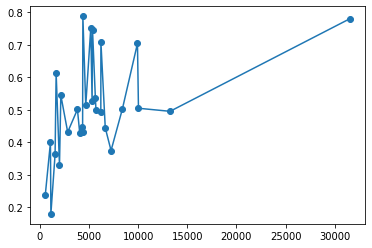

In [19]:
plt.plot(new_df.rows, new_df.optimal_F1)
plt.scatter(new_df.rows, new_df.optimal_F1)

In [26]:
new_df #everything less than 2100 rows will be few shot learnt

,roc_auc,pr_auc,optimal_threshold,optimal_F1,rows
category,,,,,
grief,0.791732,0.152627,0.066559,0.238994,560
relief,0.873349,0.286288,0.169351,0.400000,1085
pride,0.791613,0.124670,0.114218,0.180258,1128
nervousness,0.844923,0.267589,0.100541,0.363095,1557
remorse,0.890602,0.537044,0.329823,0.612676,1664
embarrassment,0.816222,0.291714,0.124696,0.330532,2004
fear,0.891496,0.556307,0.364123,0.544892,2142
desire,0.868612,0.428792,0.331717,0.431907,2838
surprise,0.870333,0.519477,0.554133,0.501558,3830


In [3]:
setfit_model = SetFitModel.from_pretrained("setfit")